# Data Assimilation on the Lorenz 63 model
## Introduction, and model definition

In [9]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")
from DA_PoC.dynamicalsystems.lorenz63 import Lorenz63Model
rng = np.random.default_rng(seed=63)

In [10]:
state_dimension = 3
dt = 0.02
Lorenz63Model.dt = dt  # By default, integration is done using RH=K4
period_assim = 5


burn = 5000
truth = Lorenz63Model()
truth.set_initial_state(-burn * dt, np.array([0, 1, 0]))
truth.forward(burn)  # Burn-in period
def generate_observations(i):
    truth.forward(period_assim)
    y = truth.state_vector[:, -1] + rng.multivariate_normal(mean=np.zeros(3), cov=np.eye(3)) * sigobs
    return truth.t[-1], y
initial_state = truth.state_vector[:, -1]


H = np.atleast_2d(
    [
        [1, 0, 0],
        [0, 1, 0],
    ]
)
sigobs = 2
R = sigobs * np.atleast_2d( # which is the dimension in the observation space
    [
        [1, 0],
        [0, 1],
    ]
)
n_total_obs = 500
observations_vector = []
obs = np.empty((3, n_total_obs))
time_obs = np.empty(n_total_obs)
for i in range(n_total_obs):
    generated = generate_observations(i)
    observations_vector.append(generated)
    obs[:, i] = generated[1]
    time_obs[i] = generated[0]

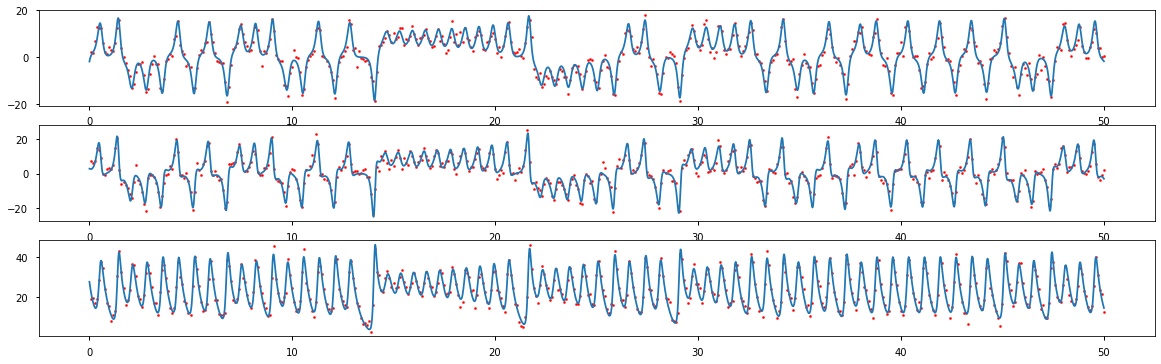

In [11]:
plt.figure(figsize=(20, 6))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(truth.t[burn+1:], truth.state_vector[i, burn+1:])
    plt.scatter(time_obs, obs[i, :], marker="o", c="red", s=5)
plt.show()

## Extended Kalman Filter

Since Lorenz93 model is non-linear, we cannot directly apply the Kalman Filter. However, by providing the linearizations of the model and of the observation operator, we can run the **Extended Kalman Filter**.

`Lorenz63Model` class owns the `TLM` method, which evaluates the Jacobian matrix of the forward model at a given point:

In [12]:
Lorenz63Model.TLM([12, 1, 0])

array([[-10.        ,  10.        ,   0.        ],
       [ 28.        ,  -1.        , -12.        ],
       [  1.        ,  12.        ,  -2.66666667]])

In [13]:
import DA_PoC.filters.kalmanfilter as KF
kalmanfilter = KF.KalmanFilter(state_dimension=3)

In [14]:
kalmanfilter.R = R # Set the observation error covariance matrix
kalmanfilter.H = H # Set the linear observation operator
kalmanfilter.Q = 0.1 * np.eye(3)
kalmanfilter.set_forwardmodel(lambda x: Lorenz63Model.integrate(0, x, period_assim)[1][:, -1])
kalmanfilter.linearM = Lorenz63Model.TLM
kalmanfilter.set_x0(np.array([0, 1, 0]), P0 = np.eye(3))


/mnt/c/Users/a846735/DA_sandbox/notebooks/../DA_PoC/filters/kalmanfilter.py:66: UserWarning: The forward model has been set with an arbitrary function. Set a linearization of M in self.linearM
  warnings.warn(


In [15]:
Nsteps = n_total_obs
result_KF = kalmanfilter.run(Nsteps=Nsteps, get_obs = lambda i: observations_vector[i])

  0%|          | 0/500 [00:00<?, ?it/s]

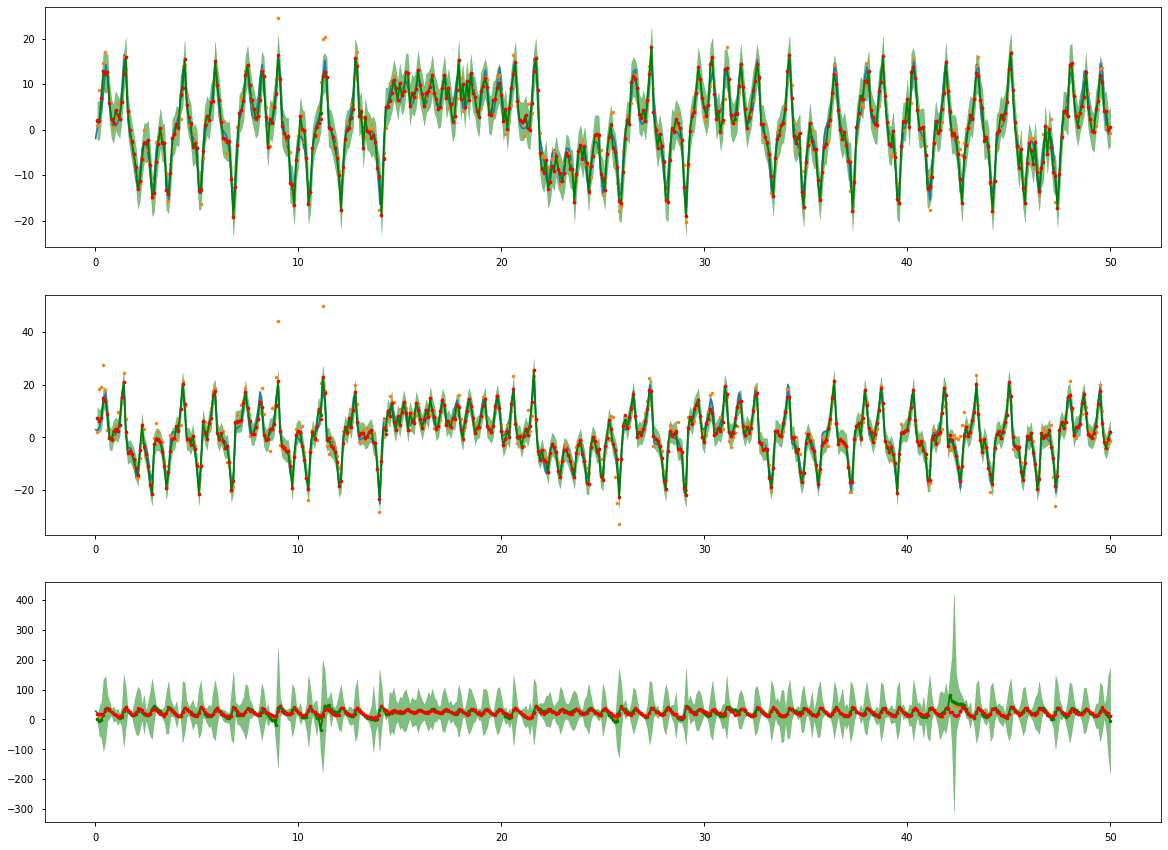

In [34]:
xf = np.array(result_KF["xf"])
xa = np.array(result_KF['xa'])
time = np.array(result_KF['time'])
obs = np.array(result_KF['observations'])
var_analysis = np.diagonal(np.array(result_KF['Pa']), axis1=1, axis2=2)
ub = xa + 3 * np.sqrt(var_analysis)
lb = xa - 3 * np.sqrt(var_analysis)
plt.figure(figsize = (20, 15))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(truth.t[burn +1: (burn + Nsteps*period_assim): period_assim], truth.state_vector[i, burn +1:(burn + Nsteps*period_assim):period_assim])
    plt.plot(time, xf[:, i], '.')
    plt.plot(time, xa[:, i], 'g.-')
    plt.fill_between(time, ub[:, i], lb[:, i], color='green', alpha=0.5)
    plt.plot(time, obs[:, i], 'r.')


## Ensemble Kalman Filter (Stochastic)

In [37]:
from DA_PoC.filters.EnKF import EnKF

In [41]:
Nensemble = 50
inflation_factor = 1.1


enkf = EnKF(state_dimension, Nensemble, R, inflation_factor, rng)
enkf.H = H
enkf.set_forwardmodel(lambda x: Lorenz63Model.integrate(0, x, period_assim)[1][:, -1])
enkf.generate_ensemble(mean=initial_state, cov=np.eye(state_dimension), rng=rng)

In [39]:
dEnKF = enkf.run(Nsteps, get_obs = lambda i: observations_vector[i])

  0%|          | 0/500 [00:00<?, ?it/s]

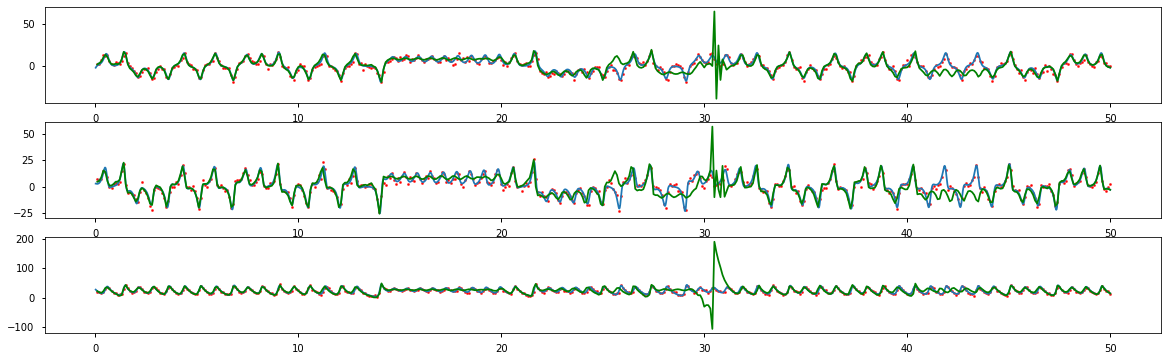

In [40]:
xabar = np.array(dEnKF["ensemble_a"]).mean(-1)
xa_std = np.array(dEnKF["ensemble_a"]).std(-1)
xbarpstd = xabar +  3 * xa_std
xbarmstd = xabar - 3 * xa_std
obs_ = np.array(dEnKF["observations"])
plt.figure(figsize=(20, 6))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(truth.t[5001:], truth.state_vector[i, 5001:])
    plt.scatter(dEnKF["time"], obs_[:, i], marker="o", c="red", s=5)
    plt.plot(dEnKF["time"], xabar[:, i], "-", color="green")
    # plt.vlines(dEnKF["time"], xabar[:, i], obs_[:, i])
    plt.fill_between(dEnKF["time"], xbarmstd[:, i], xbarpstd[:, i], alpha=0.3)
plt.show()